## Try and train a model to predict coordinates using the new train test split

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

from sklearn.decomposition import PCA
import umap

from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from skopt import gp_minimize
from skopt.space import Real, Integer
from plotnine import *

In [2]:
# Load the data
path = "/p/project1/hai_fzj_bda/koenig8/ot/data/"
adata_st = sc.read_h5ad(os.path.join(path, "adata_st.h5ad"))
adata_histo = sc.read_h5ad(os.path.join(path, "adata_histo.h5ad"))
adata_st, adata_histo

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 190659 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample', 'test_set', 'val_set', 'train_set'
     obsm: 'brain_area_onehot', 'brain_area_similarities', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

In [3]:
train_cond = adata_histo.obs.train_set
val_cond = adata_histo.obs.val_set
X_train = adata_histo.obsm["uni_pca_95"][train_cond]
y_train = adata_histo.obs.loc[train_cond, ('x_st', 'y_st', 'z_st')].to_numpy()
X_val = adata_histo.obsm["uni_pca_95"][val_cond]
y_val = adata_histo.obs.loc[val_cond, ('x_st', 'y_st', 'z_st')].to_numpy()

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((96517, 368), (96517, 3), (36112, 368), (36112, 3))

In [4]:
# Try multiple alpha values to find the best one
alphas = np.logspace(-2, 5, 20)  # from 1e-4 to 1e4
best_model = None
best_alpha = None
best_val_score = float("inf")
best_r2_score = None
print("alpha, train_r2, val_r2")

for alpha in alphas:
    model = clf = make_pipeline(
        StandardScaler(),
        Ridge(alpha=alpha)
    )
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    # Predict on validation
    y_val_pred = model.predict(X_val)
    
    # Calculate validation error
    val_score = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred, multioutput='uniform_average')
    train_r2 = r2_score(y_train, y_train_pred, multioutput='uniform_average')
    print(alpha, train_r2, val_r2)
    
    if val_score < best_val_score:
        best_val_score = val_score
        best_alpha = alpha
        best_model = model
        best_r2_score = val_r2

print(f"Best alpha: {best_alpha}")
print(f"Validation MSE: {best_val_score}, Validation R2: {best_r2_score}")

alpha, train_r2, val_r2
0.01 0.6857567591740005 -1.6816492970671746


KeyboardInterrupt: 

Still works poorly

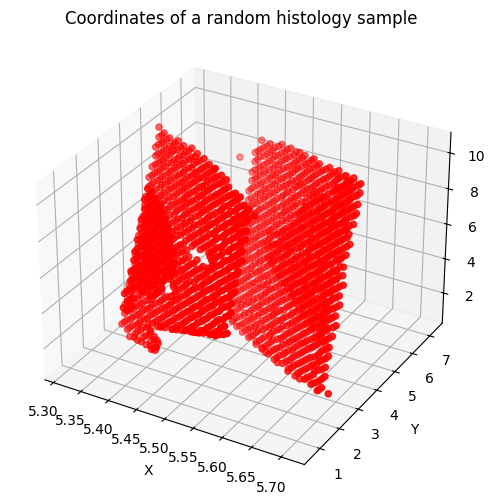

In [33]:
fig = plt.figure(figsize=(12, 6))

# First subplot for df1
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
df1 = adata_histo.obs[adata_histo.obs.image_nr == 100960301]
ax1.scatter(df1['x_st'], df1['y_st'], df1['z_st'], c='red', marker='o')
ax1.set_title('Coordinates of a random histology sample')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

plt.show()

In [34]:
image_path = "/p/project1/hai_fzj_bda/berr1/Data/atlas_images"
img = np.array(Image.open(os.path.join(image_path, "100960301.jpg")))
img.shape, img.min(), img.max()

((7664, 10384, 3), np.uint8(5), np.uint8(255))

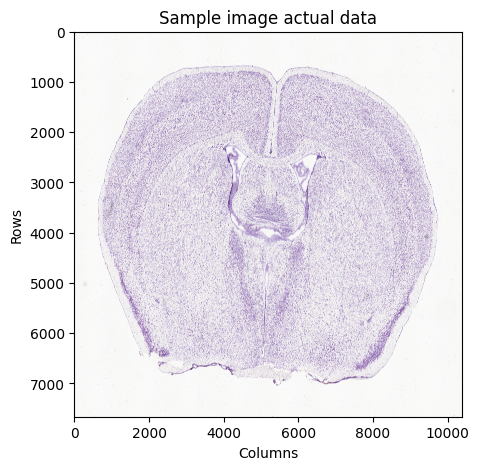

In [35]:
plt.figure(figsize=(5, 5))  # Adjust size
plt.imshow(img, aspect="auto")  # Use "viridis" or another colormap
plt.title("Sample image actual data")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [23]:
csv_path = "/p/project1/hai_fzj_bda/berr1/Data/full_data.csv"
df = pd.read_csv(csv_path).drop(columns=('Unnamed: 0'))
df.head(1)

,image_id,patchsize,center_ccf,pixel_coord,distance,nearest_ST,nearest_cell_id,target_atlas_plate,distance_new,x,y,z,x_st,y_st,z_st,image_nr,brain_area,group
0,100960033_0,256,"{'x': 9041.303566238017, 'y': 608.440707597615...","{'center_x': 3600, 'center_y': 750, 'x_min': 3...",[26.96708369],"{'x': 9.015563342479185, 'y': 0.60248181810300...",1018093344101020093-5,79.0,26.967084,9041.303566,608.440708,3534.729786,9.015563,0.602482,3.52933,100960033,Isocortex,11


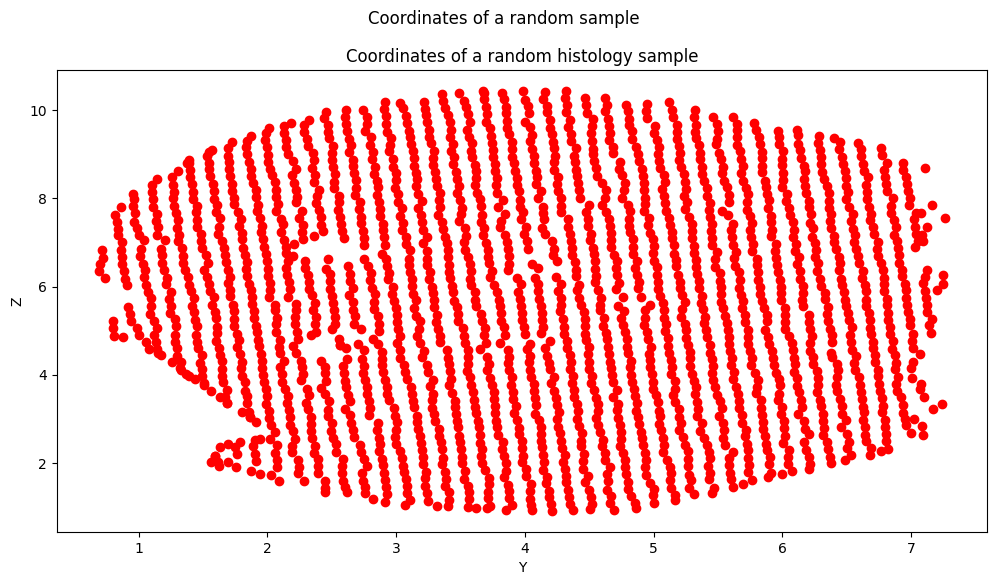

In [36]:
fig = plt.figure(figsize=(12, 6))

# First subplot for df1
ax1 = fig.add_subplot(1, 1, 1)
df1 = df[df.image_nr == 100960301]
ax1.scatter( df1['y_st'], df1['z_st'], c='red', marker='o')
ax1.set_title('Coordinates of a random histology sample')
ax1.set_xlabel('Y')
ax1.set_ylabel('Z')

plt.suptitle("Coordinates of a random sample ")
plt.show()

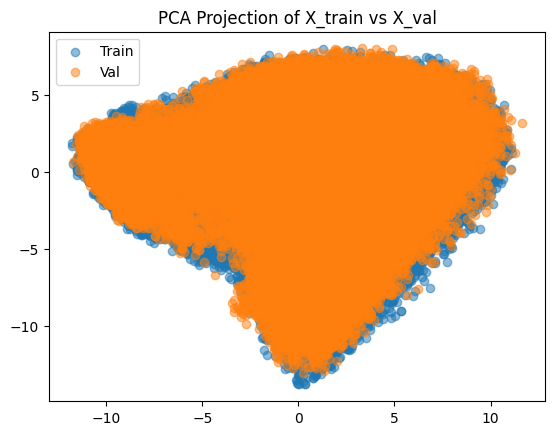

In [30]:
# Concatenate for joint PCA
X_all = np.concatenate([X_train, X_val])
pca = PCA(n_components=2).fit(X_all)

X_train_2d = pca.transform(X_train)
X_val_2d = pca.transform(X_val)

plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], label='Train', alpha=0.5)
plt.scatter(X_val_2d[:, 0], X_val_2d[:, 1], label='Val', alpha=0.5)
plt.legend()
plt.title("PCA Projection of X_train vs X_val")
plt.show()

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


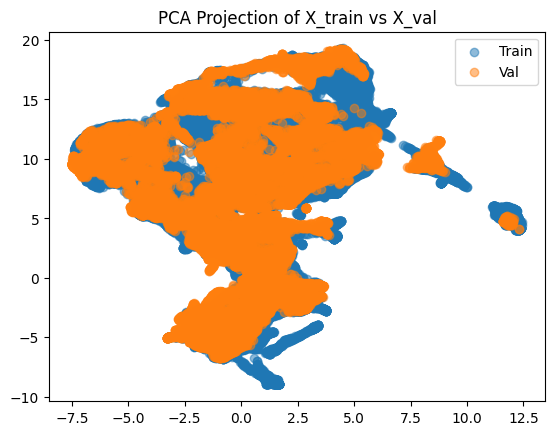

In [47]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_all)
n = X_train.shape[0]

plt.scatter(embedding[:n, 0], embedding[:n, 1], label='Train', alpha=0.5)
plt.scatter(embedding[n:, 0], embedding[n:, 1], label='Val', alpha=0.5)
plt.legend()
plt.title("PCA Projection of X_train vs X_val")
plt.show()

In [5]:
reducer = umap.UMAP(random_state=42)
embedding = pd.DataFrame(reducer.fit_transform(adata_histo.obsm["uni_embedding"]), columns = ("UMAP1", "UMAP2"))
labels = adata_histo.obs.loc[:, ('x_st', 'y_st', 'z_st')].to_numpy()
embedding["distance to origin"] = np.sqrt(np.sum(np.square(labels), axis = 1))
embedding.head()

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


,UMAP1,UMAP2,distance to origin
0,4.455162,17.695002,8.321293
1,4.591460,17.623762,8.389046
2,4.571945,17.612068,8.467179
3,4.631194,17.610016,8.536324
4,4.620399,17.577728,8.621414


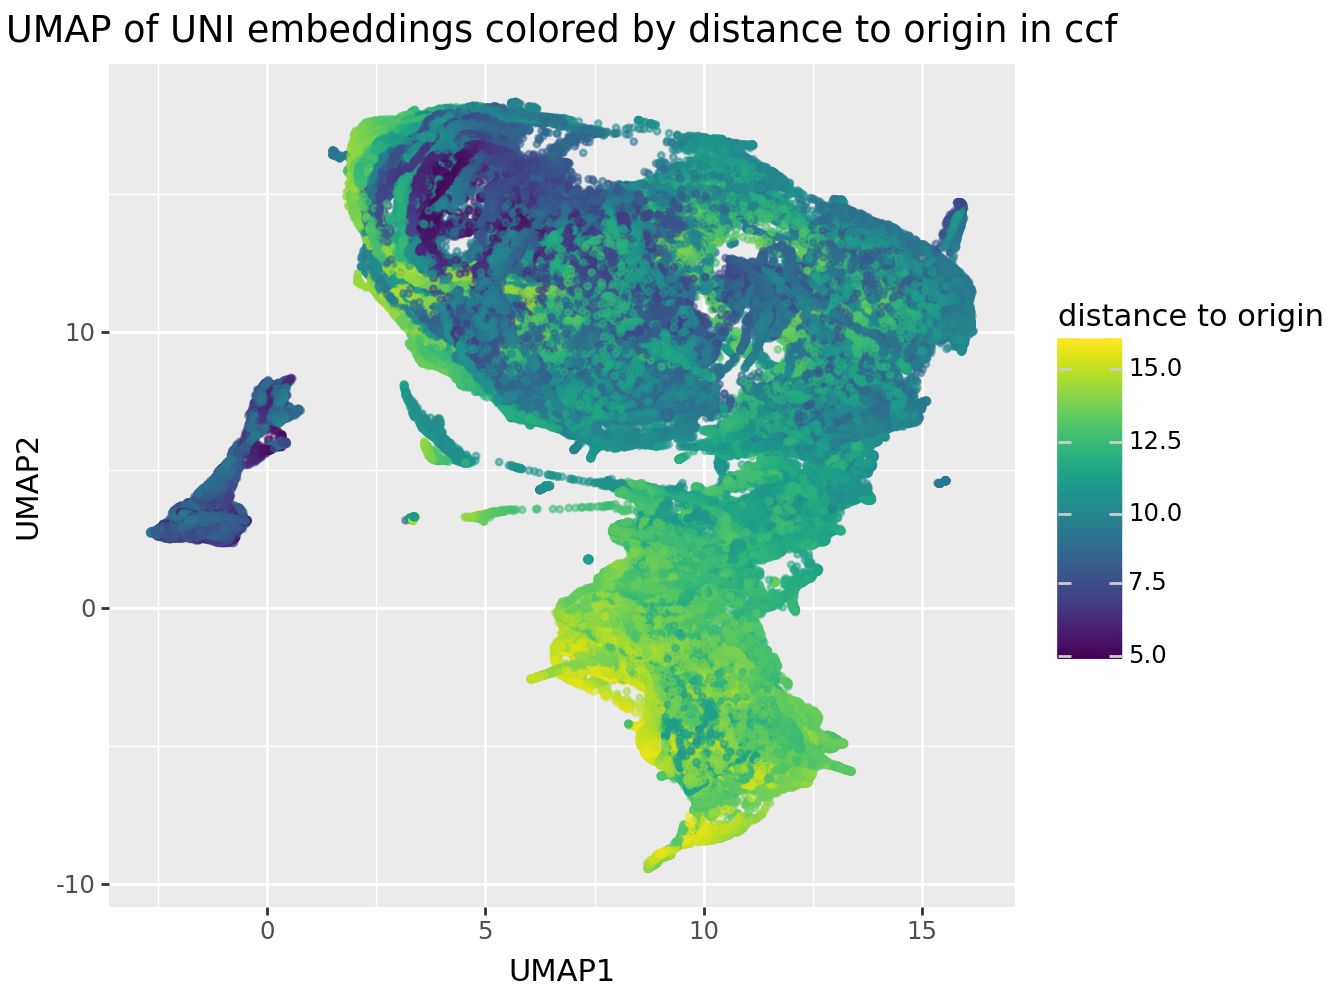

In [12]:
plot = (ggplot(embedding, aes(x= "UMAP1", y ="UMAP2", color="distance to origin")) + 
       geom_point(size=0.8, alpha = 0.5) +
        ggtitle("UMAP of UNI embeddings colored by distance to origin in ccf")+
        theme(figure_size = (6.7, 5))
       )
plot

In [37]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
val_pred = model.predict(X_val)
train_pred = model.predict(X_train)

print("Train R² (RF):", r2_score(y_train, train_pred, multioutput='uniform_average'))
print("Val R² (RF):", r2_score(y_val, val_pred, multioutput='uniform_average'))

Val R² (RF): 0.9707190479608219
Val R² (RF): -1.9668360444377644


In [6]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[128, 64], dropout=0.1):
        super(SimpleMLP, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims

        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(dims[-1], output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)

# Model, loss, optimizer
def objective(hd = 100, dropout = 0.1, lr = 1e-4, wd = 8e-4):
    model = SimpleMLP(
        input_dim=X_train.shape[1], 
        output_dim=y_train.shape[1], 
        hidden_dims=[hd,],
        dropout = dropout
    ).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    best_val_loss = np.inf
    final_train_loss = np.inf
    n_no_decrease = 0
    patience = 5
    
    # Training
    for epoch in range(100):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            pred = model(xb.to(device))
            loss = criterion(pred, yb.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
    
        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = criterion(val_pred, y_val_t)
            train_loss = np.mean(train_losses)
        
        if val_loss < best_val_loss:
            n_no_decrease = 0
            best_val_loss = val_loss.item()
            final_train_loss = train_loss
        else:
            n_no_decrease += 1
            if n_no_decrease >= patience:
                return best_val_loss
    print(f"{epoch},{hd},{dropout},{lr},{wd},{best_val_loss:.4f},{final_train_loss:.4f}")
    return best_val_loss
    
def objective_wrapper(params):
    hd, dropout, lr, wd = params
    return objective(hd, dropout, lr, wd)

In [10]:
# Define the search space for parameters
search_space = [
    Integer(50, 1000, name='hd'),   
    Real(0.1, 0.8, name='dropout'),     
    Real(1e-5, 0.01, name='lr'),
    Real(1e-8, 1e-2, name='wd')
]

print(f"epoch,hiddendim,dropout,lr,wd,best_val_loss,final_train_loss")
res = gp_minimize(objective_wrapper, search_space, n_calls=100, random_state=42)
    
best_cost = res.fun
best_cost

epoch,hiddendim,dropout,lr,wd,best_val_loss,final_train_loss
99,586,0.1,1e-05,0.01,3.4835,0.6575
99,611,0.1,1e-05,1e-08,3.1803,0.4528


np.float64(2.0566325187683105)

In [12]:
best_model = 

          fun: 2.0566325187683105
            x: [np.int64(608), 0.1, 0.01, 1e-08]
    func_vals: [ 3.126e+00  3.135e+00 ...  2.057e+00  2.211e+00]
      x_iters: [[np.int64(807), 0.2284043529063147, 0.007799113092724967, 0.005968505610963292], [np.int64(474), 0.16998244107260205, 0.004597896430739014, 0.0033370927743041076], [np.int64(186), 0.5556219310641971, 0.0005735516744807317, 0.007219990502680526], [np.int64(942), 0.10054513608871003, 0.009922193477319265, 0.00617481892146207], [np.int64(631), 0.1049464136538022, 0.00024039362616374346, 0.00524775135483729], [np.int64(430), 0.1326659642495308, 0.009737817633226179, 0.0023277210765896388], [np.int64(136), 0.5328702065331612, 0.003830795292758957, 0.009832309025759026], [np.int64(493), 0.7019582847154245, 0.006806272310491921, 0.004504998014702911], [np.int64(63), 0.7595412289793971, 0.005637249296276938, 0.0038541711712341367], [np.int64(65), 0.2616256779355044, 0.0024178444055998577, 0.006832638355619395], [np.int64(1000), 0.1,

In [31]:
model.eval()
with torch.no_grad():
    val_pred = model(X_val_t).detach().cpu().numpy()
    train_pred = model(X_train_t.to(device)).detach().cpu().numpy()

print("Train R²:", r2_score(y_train, train_pred))
print("Val R²:", r2_score(y_val, val_pred))

Train R²: 0.662503177201297
Val R²: -1.655590611778986


```
epoch,hiddendim,dropout,lr,wd,best_val_loss,final_train_loss
99,1000,0.43850891601340825,1e-05,1e-08,3.2899,0.6327
99,1000,0.1,1e-05,1e-08,3.0985,0.3677
99,105,0.25054078794115064,1e-05,1e-08,3.7859,1.2454
99,1000,0.8,1.0000000000000035e-05,0.01,3.9882,1.3734
99,710,0.1,1e-05,1e-08,3.1373,0.4247
```